
# Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation

This is an example of applying :class:`~sklearn.decomposition.NMF` and
:class:`~sklearn.decomposition.LatentDirichletAllocation` on a corpus
of documents and extract additive models of the topic structure of the
corpus.  The output is a plot of topics, each represented as bar plot
using top few words based on weights.

Non-negative Matrix Factorization is applied with two different objective
functions: the Frobenius norm, and the generalized Kullback-Leibler divergence.
The latter is equivalent to Probabilistic Latent Semantic Indexing.

The default parameters (n_samples / n_features / n_components) should make
the example runnable in a couple of tens of seconds. You can try to
increase the dimensions of the problem, but be aware that the time
complexity is polynomial in NMF. In LDA, the time complexity is
proportional to (n_samples * iterations).


In [41]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from time import time

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

n_samples = 2000
n_features = 1000
n_components = 10 # number of topics
n_top_words = 20
batch_size = 128
init = "nndsvda"

In [38]:
# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time()
data, _ = fetch_20newsgroups(
    shuffle=True,
    random_state=1,
    remove=("headers", "footers", "quotes"),
    return_X_y=True,
)
data_samples = data[:n_samples]
print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 1.056s.


In [8]:
# dataの中身を確認
print(data_samples[0])

Well i'm not sure about the story nad it did seem biased. What
I disagree with is your statement that the U.S. Media is out to
ruin Israels reputation. That is rediculous. The U.S. media is
the most pro-israeli media in the world. Having lived in Europe
I realize that incidences such as the one described in the
letter have occured. The U.S. media as a whole seem to try to
ignore them. The U.S. is subsidizing Israels existance and the
Europeans are not (at least not to the same degree). So I think
that might be a reason they report more clearly on the
atrocities.
	What is a shame is that in Austria, daily reports of
the inhuman acts commited by Israeli soldiers and the blessing
received from the Government makes some of the Holocaust guilt
go away. After all, look how the Jews are treating other races
when they got power. It is unfortunate.



In [29]:
# Use tf-idf features for NMF.
# NMFとは、非負値行列の因子分解を行う手法
# 因子分解とは、行列を複数の行列の積に分解すること
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, # max_dfは、文書頻度の最大値を指定するパラメータ
    min_df=2, # min_dfは、文書頻度の最小値を指定するパラメータ
    max_features=n_features, # max_featuresは、特徴量の最大数を指定するパラメータ
    stop_words="english" # stop_wordsは、ストップワードを指定するパラメータ
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# tfidfの型は、scipy.sparse.csr.csr_matrix となる
# csr_matrix は、Compressed Sparse Row matrixの略で、疎行列を効率的に扱うためのクラス
print(tfidf.toarray())
# 例: tfidf_vectorizer.vocabulary_.items()からvalueが708のkeyを取得
# print([k for k, v in tfidf_vectorizer.vocabulary_.items() if v == 708])

Extracting tf-idf features for NMF...
done in 0.294s.
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.08365563 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.12574832 0.04605022 0.06032677]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [35]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print(tf.toarray())

Extracting tf features for LDA...
done in 0.283s.
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 3 1 1]
 [0 0 0 ... 0 0 0]]
1000


Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.114s.


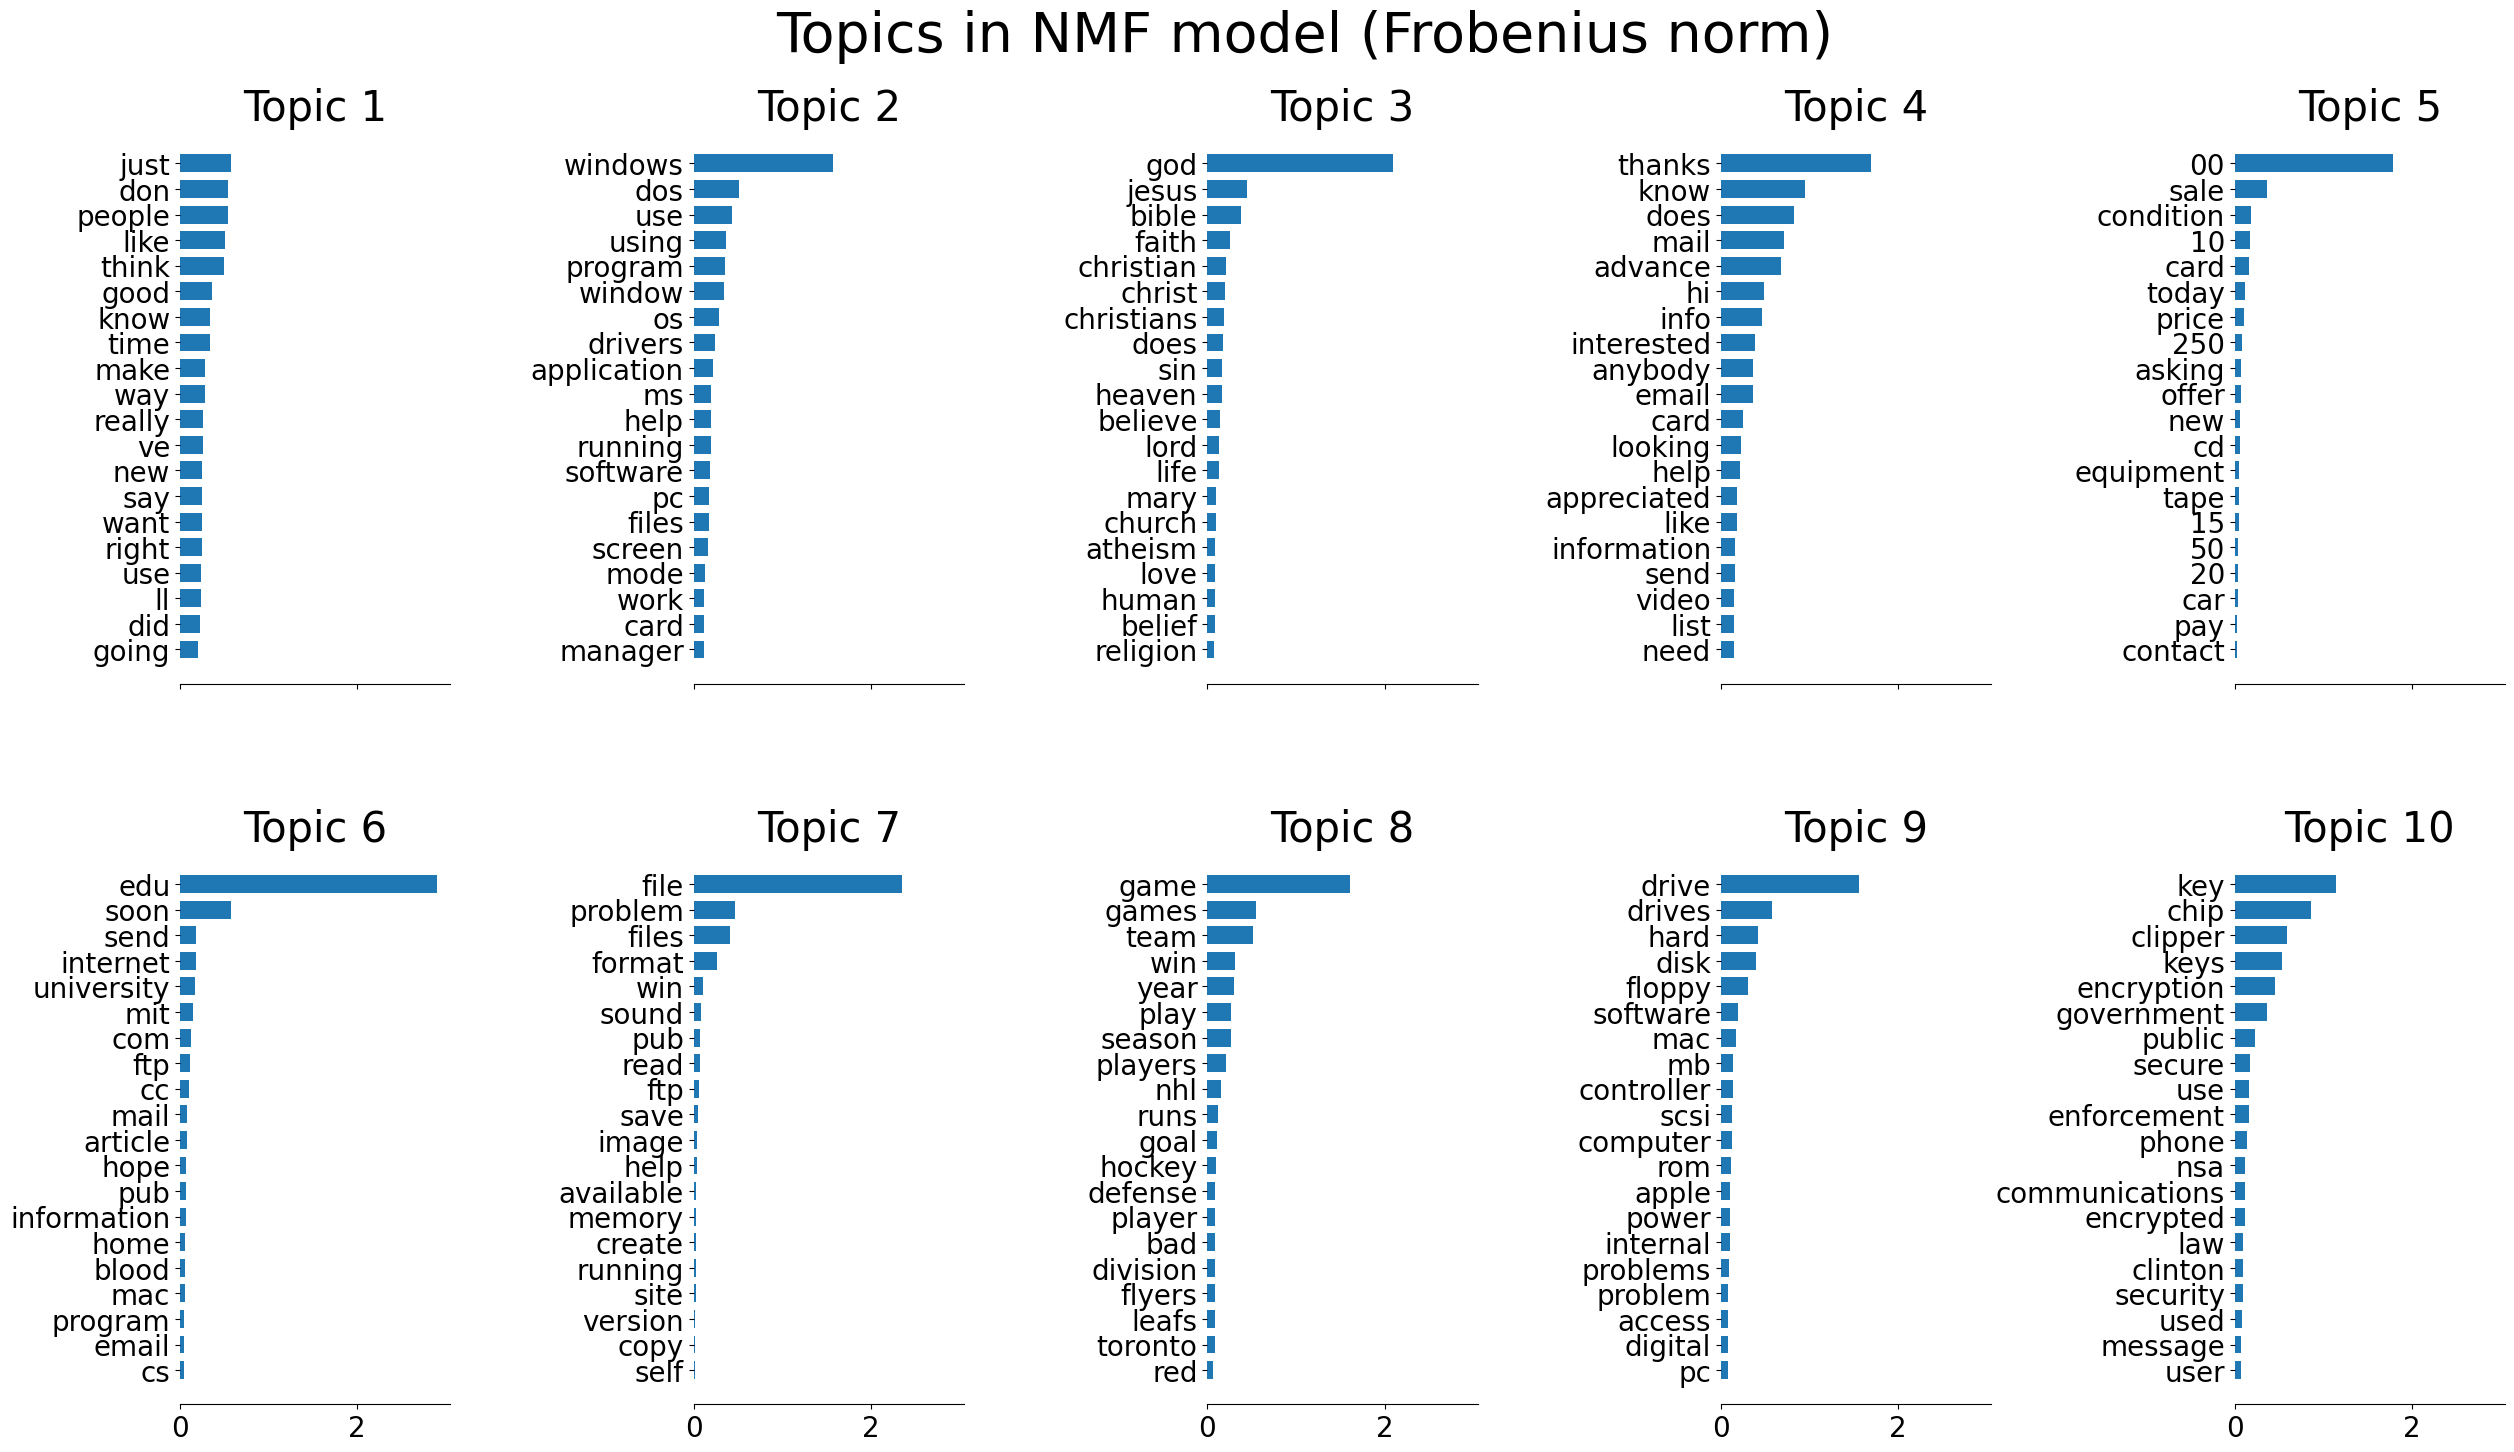

In [45]:
def plot_top_words(model, feature_names, n_top_words, title):
    """
    Plot the top words for each topic in a given model.

    Parameters:
    - model: The topic model to visualize.
    - feature_names: The names of the features (words).
    - n_top_words: The number of top words to display for each topic.
    - title: The title of the plot.

    Returns:
    None
    """
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        # topic.argsort()で要素の値が小さい順に並び替えたインデックスを返し、[-n_top_words:]で後ろからn_top_words個取得することで、上位n_top_words個のインデックスを取得
        top_features_ind = topic.argsort()[-n_top_words:]
        # feature_namesとtopicは並び順が対応しているため、top_features_indを使って上位n_top_words個の特徴量名と重みを取得
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        # ax.barh とは水平方向に棒グラフを描画する関数
        # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.barh.html#matplotlib-axes-axes-barh
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        # ax.tick_params は目盛りの設定を行う関数
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            # ax.spinesはグラフの枠線を表す
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Fit the NMF model
# NMFとは Non-negative Matrix Factorization の略で、非負値行列の因子分解を行う手法
# Frobenius normとは、行列の要素の二乗和の平方根
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1, # 乱数のシード
    init=init, # 初期化方法
    beta_loss="frobenius", # beta_lossは、損失関数を指定するパラメータ. "frobenius"は、フロベニウスノルムを使う. フロベニウスノルムは、行列の要素の二乗和の平方根
    alpha_W=0.00005, # alpha_Wは、Wの正則化パラメータ
    alpha_H=0.00005, # alpha_Hは、Hの正則化パラメータ
    l1_ratio=1, # l1_ratioは、L1正則化の割合を指定するパラメータ
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

# tfidf_vectorizer.get_feature_names_out()は、特徴量の名前を取得するメソッド
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 1.101s.


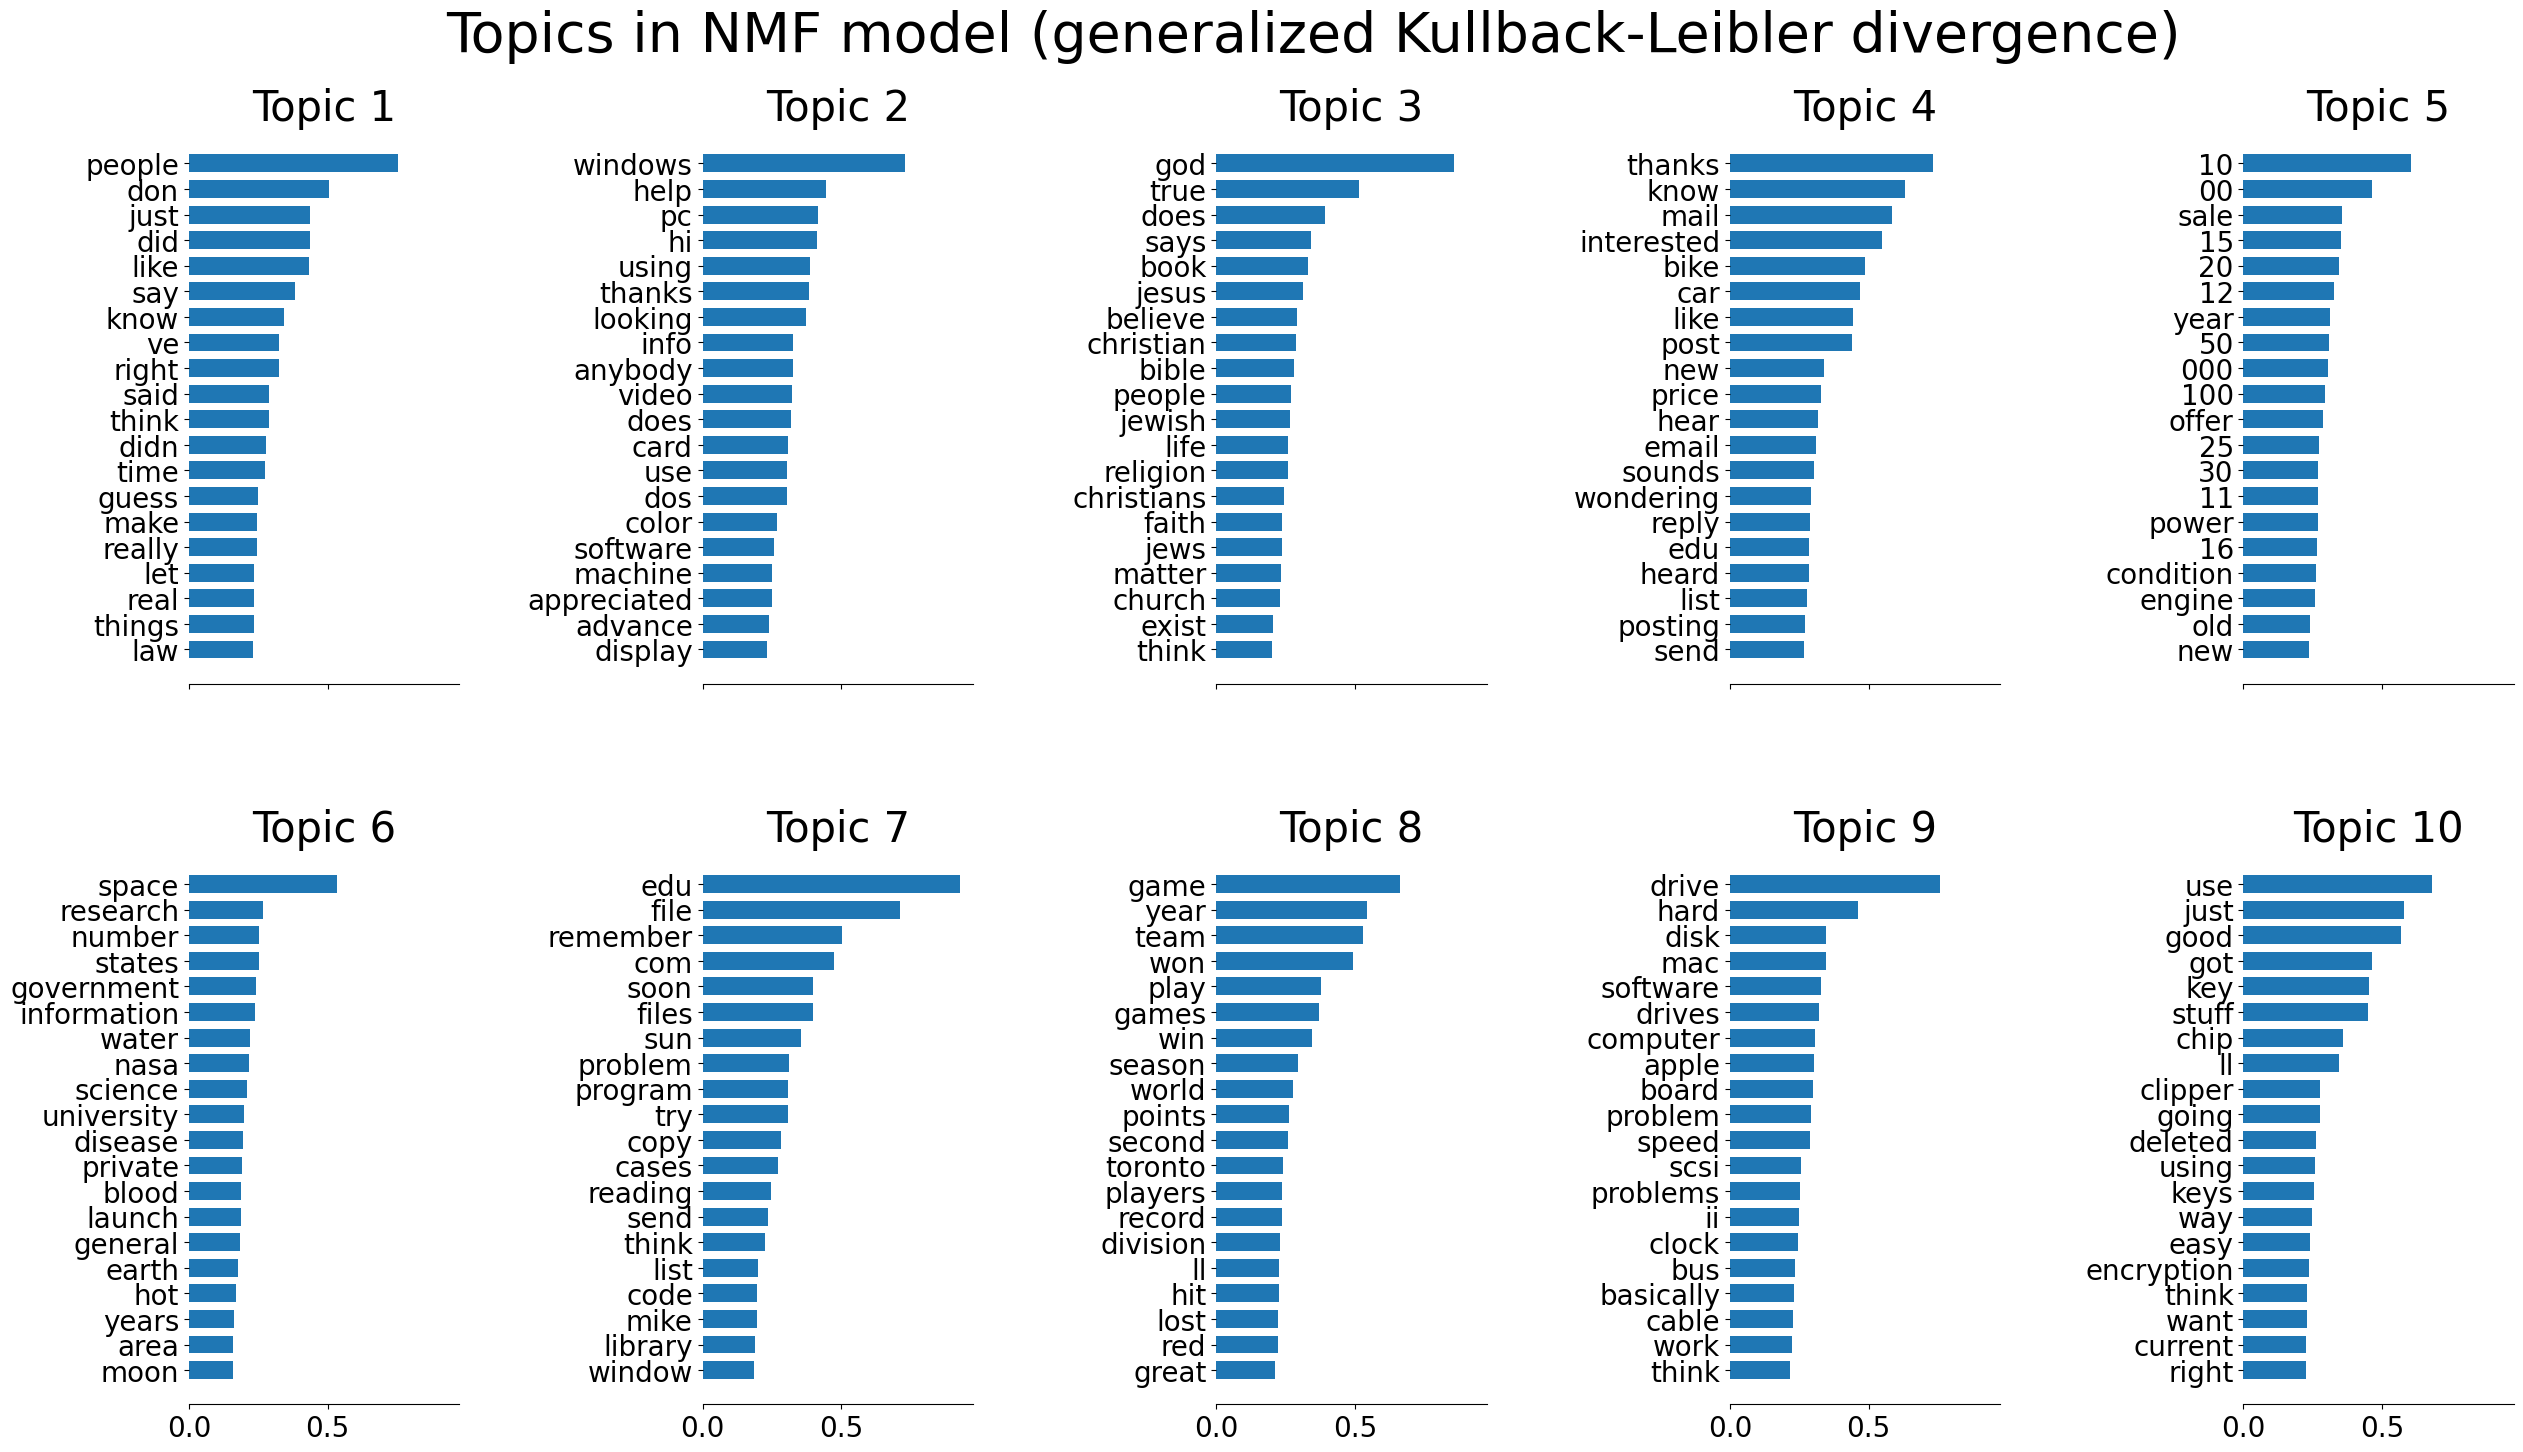



 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...
done in 0.105s.


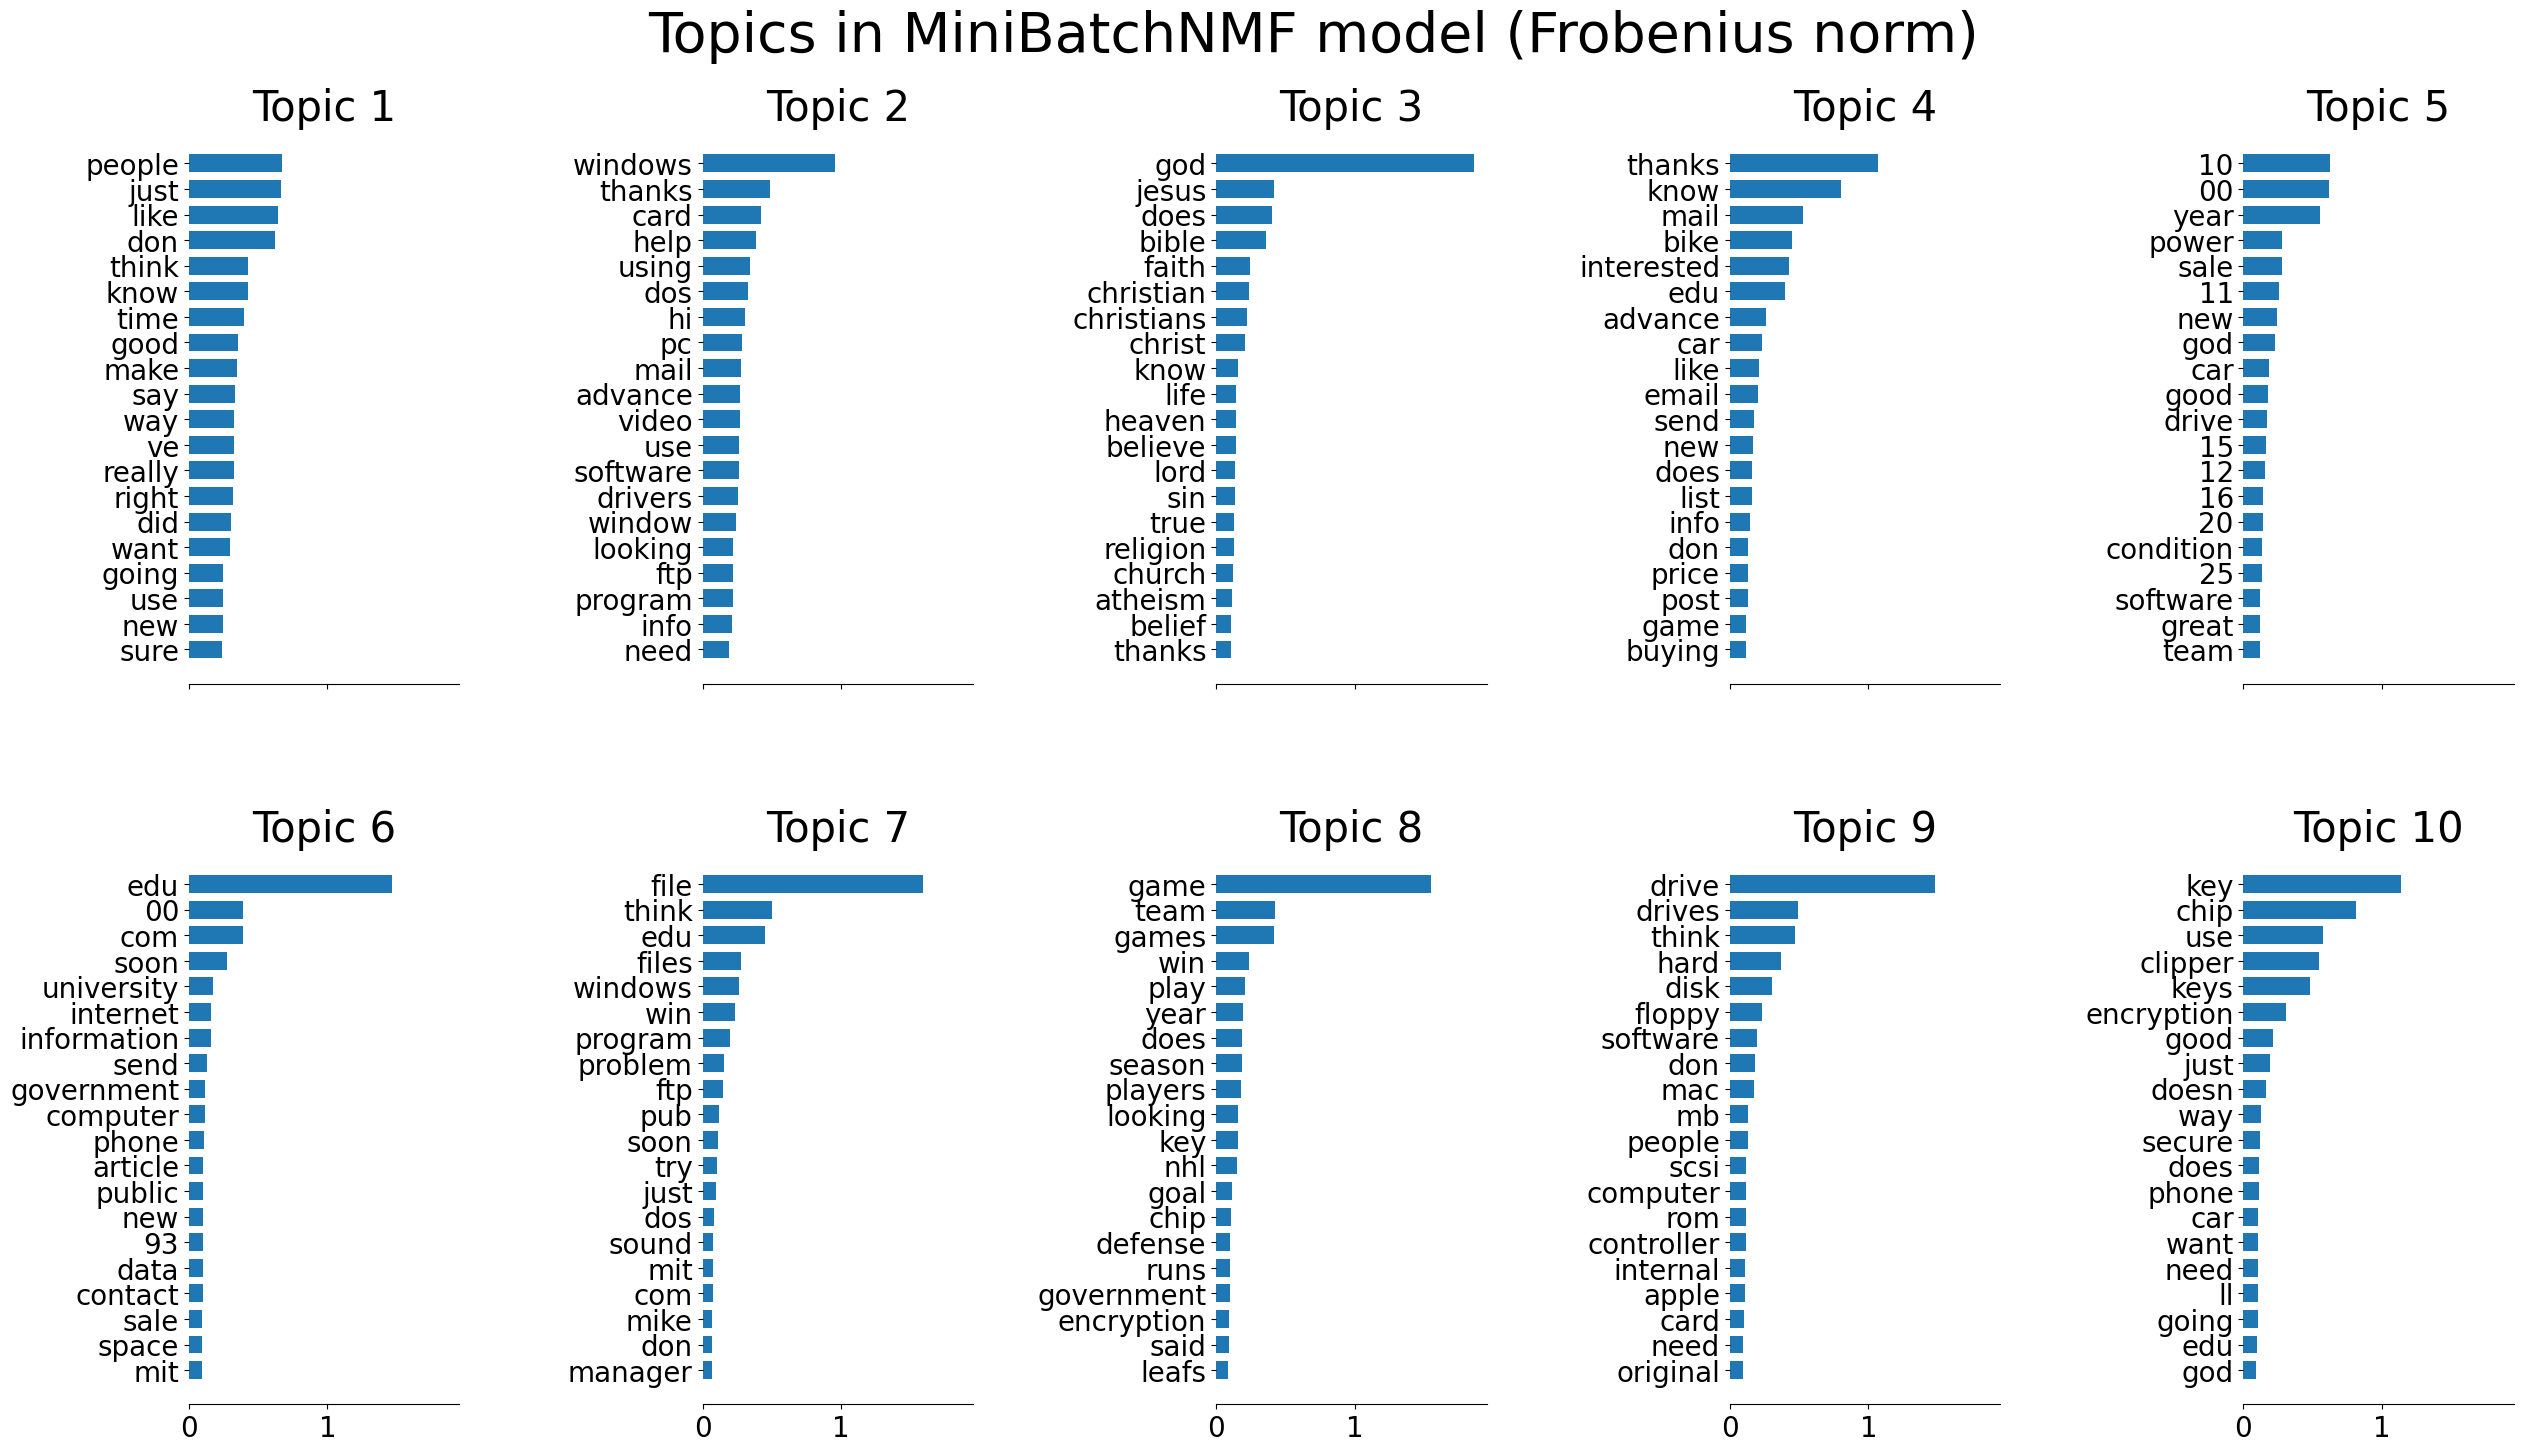



 Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...
done in 0.258s.


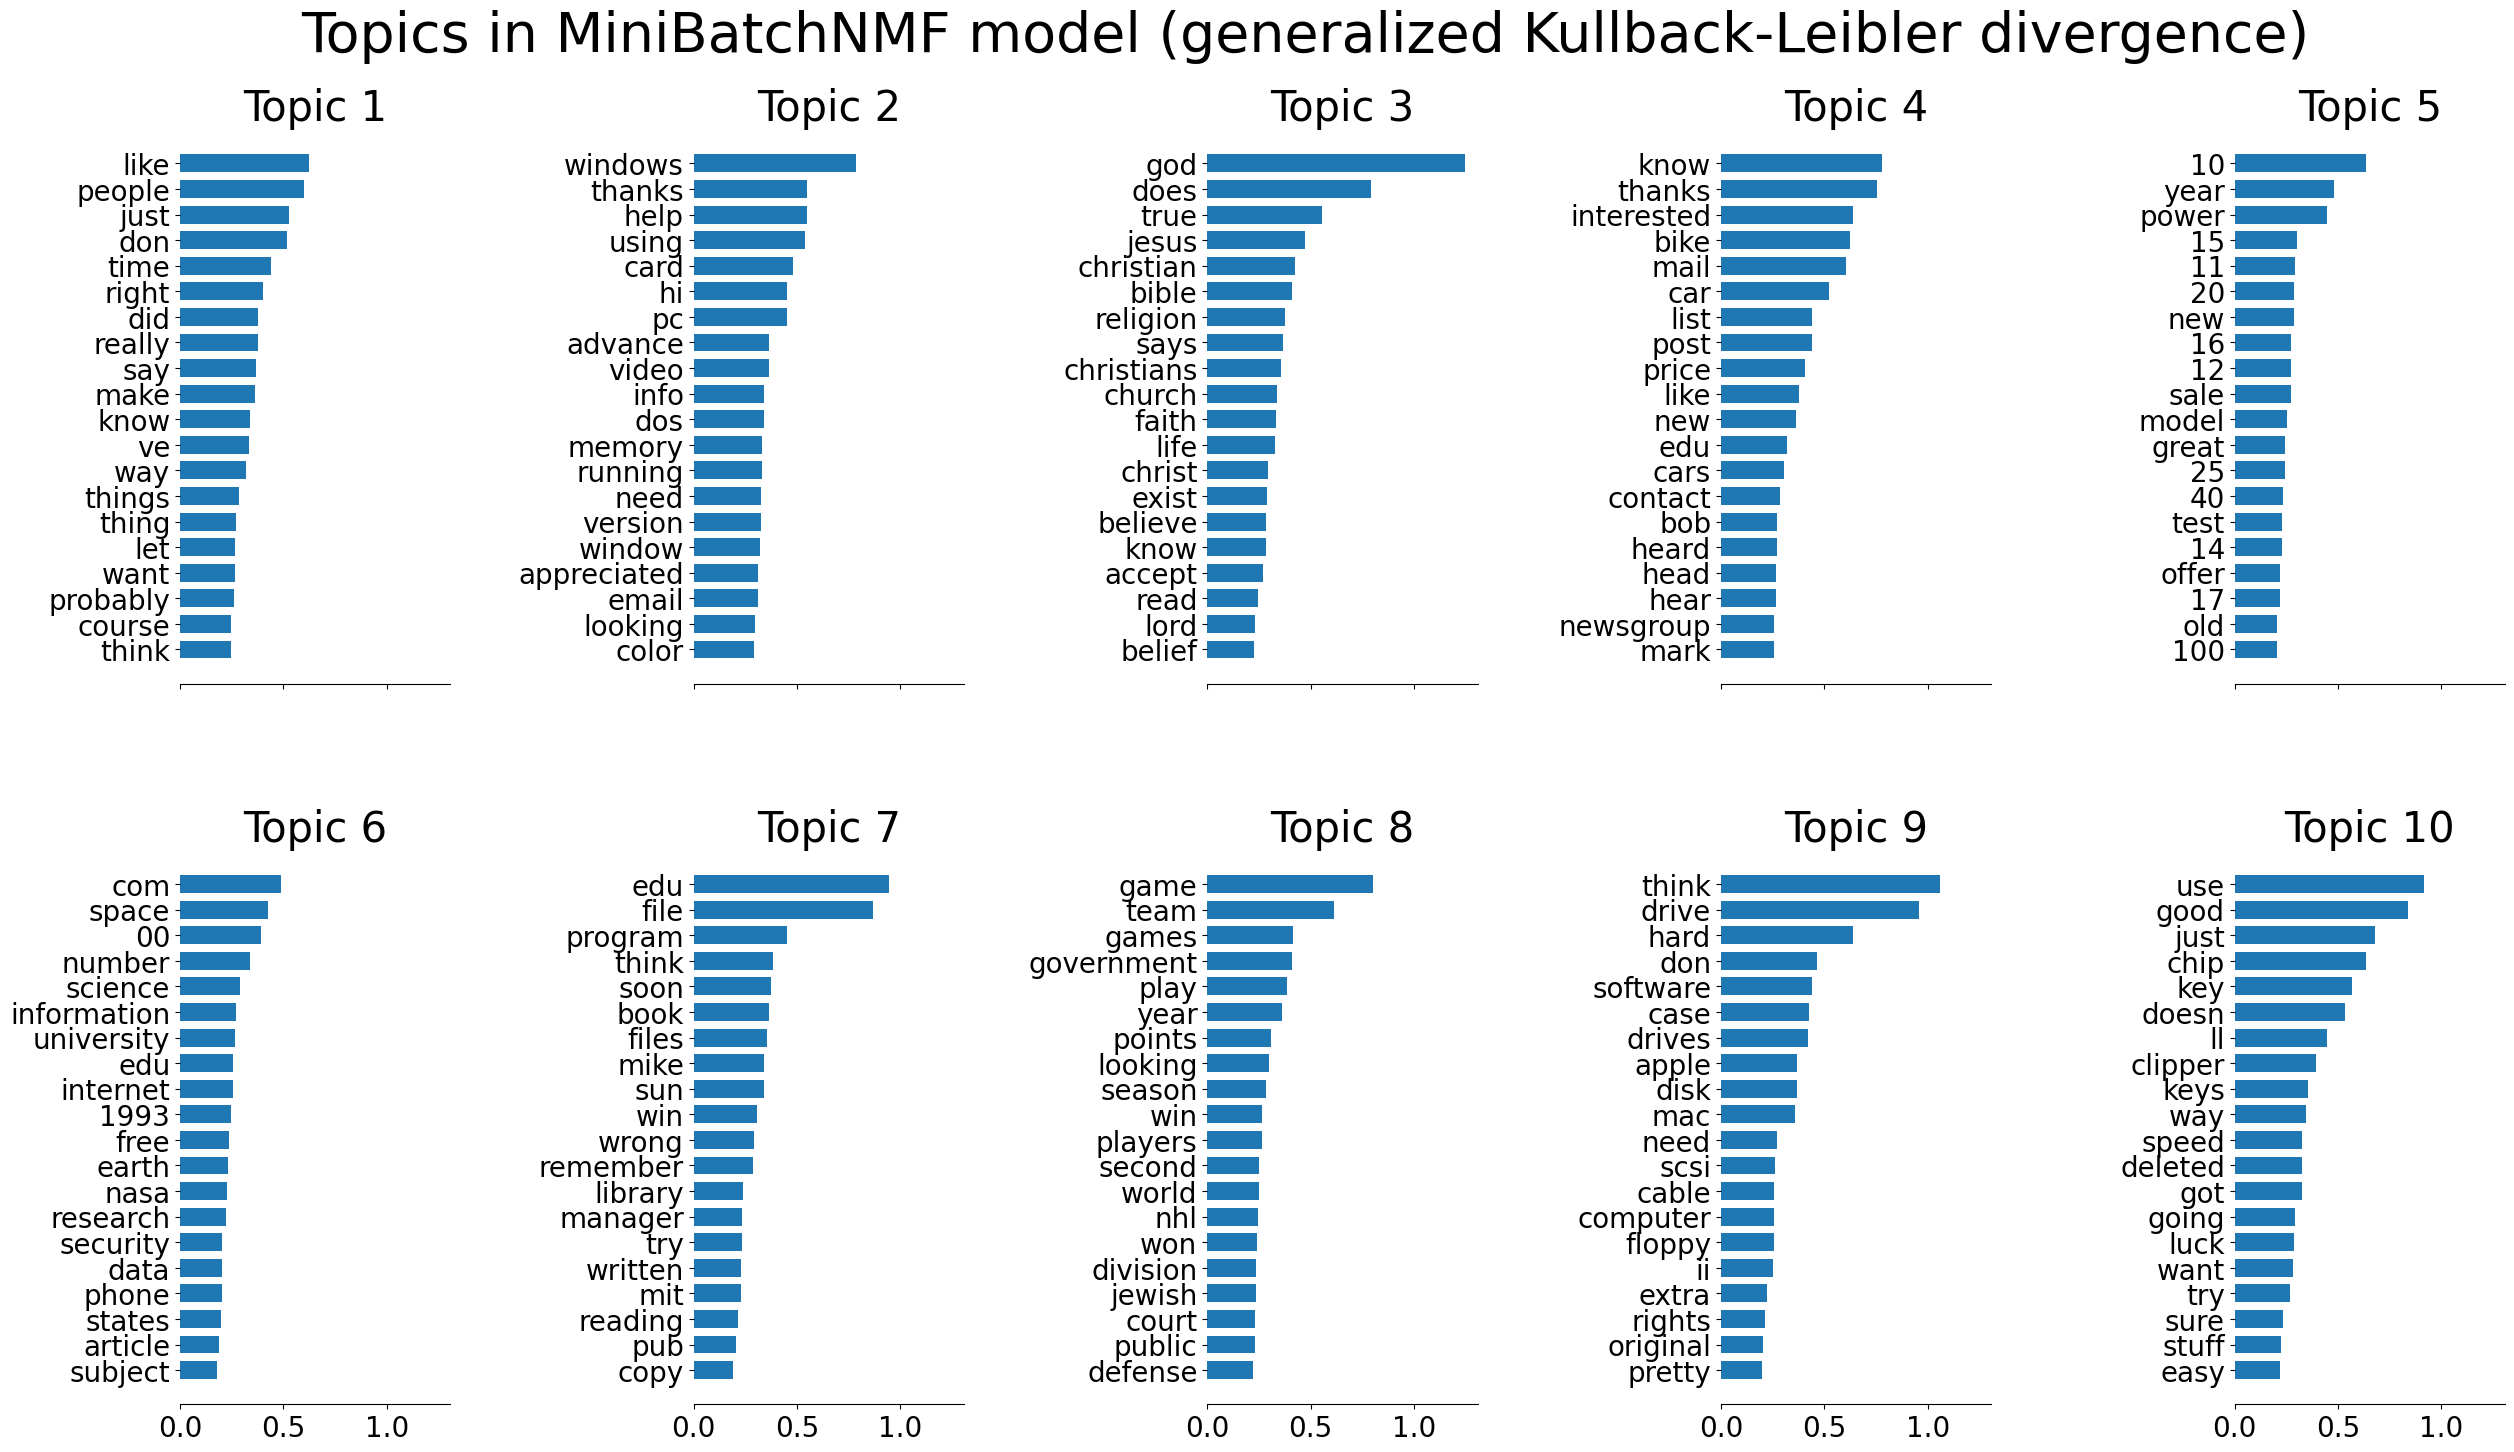



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 2.433s.


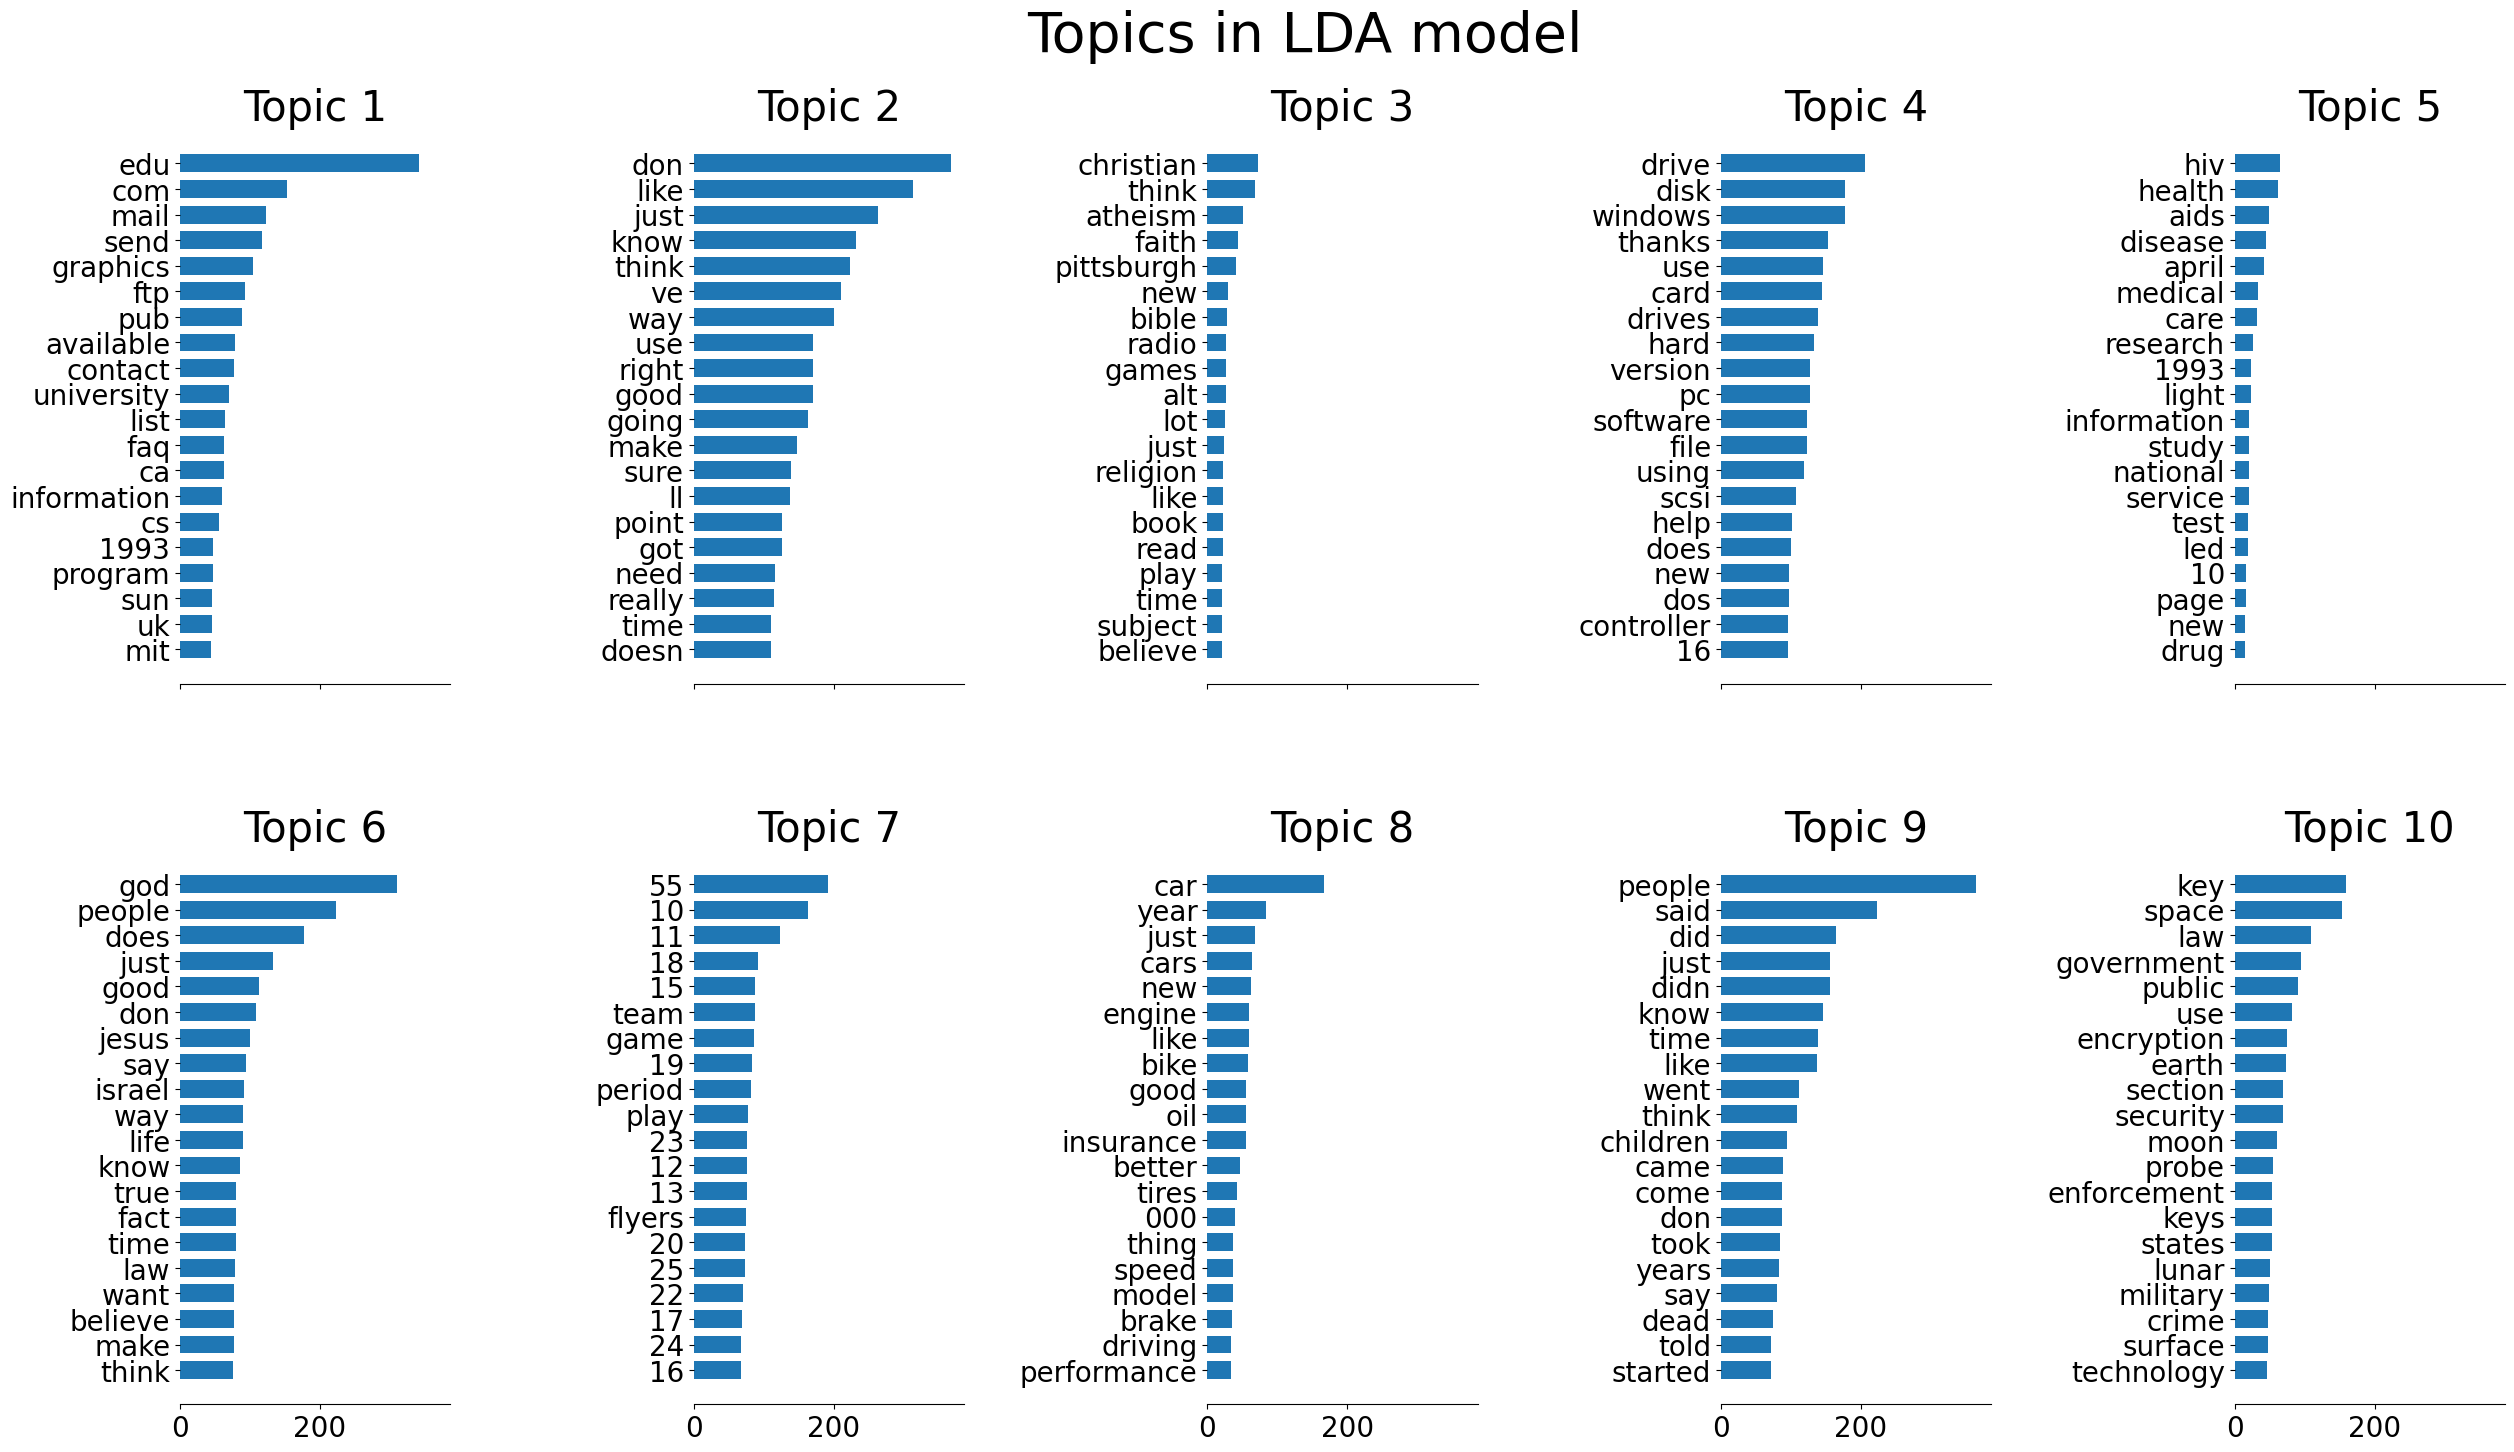

In [46]:
# Fit the NMF model
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    "features, n_samples=%d and n_features=%d, batch_size=%d..."
    % (n_samples, n_features, batch_size),
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d, "
    "batch_size=%d..." % (n_samples, n_features, batch_size),
)
t0 = time()
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")